# Classifing Coral

###### By:

Jared H. Mitchell

# Overview

In twenty 2016, coral bleaching killed 29%-50% of the great barrier reefs coral. Mass bleaching events like this one are unfortunately becoming more and more common. In order to help the organization The Great Reef Census, I came up with this project idea. The Great Reef Census takes a lot of user submitted photos based on surveys of the reef done by volunteers. I thought it could be useful to build a machine learning model that could classify between images of dead, living, and bleached coral. This could then be used with their already inplace system to further montiter reef health. Successfully classing all of the photos would provide the organization with a general idea of the reefs health by using the percentage of living, dead, and bleached coral photos in an area.

# The Data

The data that I will be using to build, train, and test our model with is a public data set from [Kaggle](https://www.kaggle.com/sonainjamil/bhd-corals). I started by importing my needed packages, and then using ImageDataGenerator from keras to import all of our images while formatting them in the process.

In [12]:
# Importing packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Loading in all images
train_datagen = ImageDataGenerator(
        rescale=1./255)
training_data = train_datagen.flow_from_directory(
        'Data\Train',
        target_size=(244, 244),
        batch_size=32,
        seed = 626,
        class_mode='categorical')
testing_data = train_datagen.flow_from_directory(
        'Data\Test',
        target_size=(244, 244),
        batch_size=32,
        seed = 626,
        class_mode='categorical')

Found 1453 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


The above cell shows us that our training set has 1,455 images belonging to three different classes, and the testing set is 141 images belonging to 3 different classes. The images are all 244 by 244 pixels and all fall within the class of "living", "bleached", and "dead". Unfortunately we do have a large class imbalance among the images. Inside the training set we have 646 images of living coral, 659 images of bleached coral, but only 150 images of dead coral. This is unfortunately a limitation of this data set. 

Thankfully, we can use image augmentation to effectively help increase the number of images in each class. I will be implementing this in my final model and talk more about the process then. For now, let's move onto my first model. For the sake of time, I implemented some early stopping so I didn't waste time on unneeded Epochs. The first model was just your basic Dense Neural Network. I wanted to get a baseline performance that I could improve on when building my final Convolutional Neural Network.

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7) # Sets up Early Stopping

In [15]:
model = Sequential([Flatten(),                     # My basic baseline model
                    Dense(512, activation = 'relu'),
                    Dense(256, activation = 'relu'),
                    Dropout(rate=0.5),
                    Dense(3, activation = 'softmax')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
trained_model = model.fit(training_data,         # Fitting our basic model
                    validation_data=testing_data,
                    epochs = 30,
                    verbose = 1,
                    callbacks= [early_stopping])

Epoch 1/30
46/46 [==============================] - 17s 354ms/step - loss: 29.7837 - accuracy: 0.5024 - val_loss: 3.5434 - val_accuracy: 0.6241
Epoch 2/30
46/46 [==============================] - 13s 289ms/step - loss: 2.5553 - accuracy: 0.5760 - val_loss: 0.5721 - val_accuracy: 0.7234
Epoch 3/30
46/46 [==============================] - 13s 285ms/step - loss: 0.8255 - accuracy: 0.6235 - val_loss: 0.6396 - val_accuracy: 0.7021
Epoch 4/30
46/46 [==============================] - 13s 286ms/step - loss: 0.7503 - accuracy: 0.6710 - val_loss: 0.6174 - val_accuracy: 0.7730
Epoch 5/30
46/46 [==============================] - 13s 288ms/step - loss: 0.7548 - accuracy: 0.6820 - val_loss: 0.6506 - val_accuracy: 0.6950
Epoch 6/30
46/46 [==============================] - 13s 289ms/step - loss: 0.7211 - accuracy: 0.6958 - val_loss: 0.5816 - val_accuracy: 0.7943
Epoch 7/30
46/46 [==============================] - 13s 287ms/step - loss: 0.7322 - accuracy: 0.6813 - val_loss: 0.5662 - val_accuracy: 0.780

5/5 [==============================] - 0s 63ms/step - loss: 0.5278 - accuracy: 0.8085
[0.5277513265609741, 0.8085106611251831]


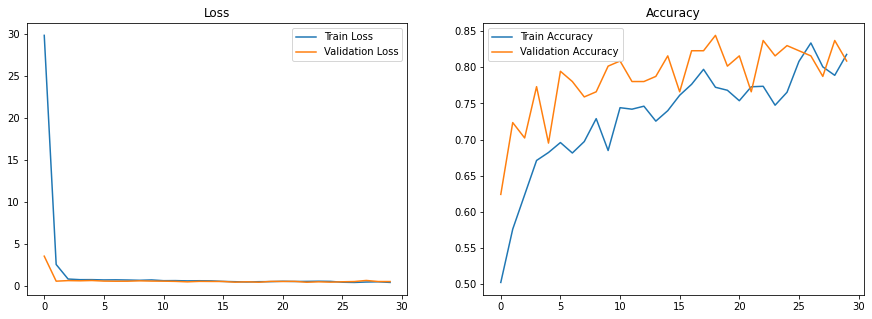

In [17]:
# Plots the accuracy and loss over each epoch
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Loss')
ax[0].plot(trained_model.epoch, trained_model.history["loss"], label="Train Loss")
ax[0].plot(trained_model.epoch, trained_model.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(trained_model.epoch, trained_model.history["accuracy"], label="Train Accuracy")
ax[1].plot(trained_model.epoch, trained_model.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[1].legend()
print(model.evaluate(testing_data))

### Baseline Analysis

Our baseline had a final accuracy score of 80%. This is better than just picking at random, but I definitely think a far more complex Convolutional Neural Network would perform a lot better.

## Building a Better Nerual Network

One of the first things I implemented was image augmentation. I applied the augmentation through the ImageDataGeneratror. Each of the settings you see inside of the cell below is a different type of image augmentation. Each changes the image in small ways, some zoom in, others rotate the image, and a few flip the image. The ImageDataGenerator will apply one of these to each image during each Epoch the Neural Network goes over. This effectively greatly increases the variety of images that we get to train on. 

In order to make sure that we're training on as many variations of each image as possible we're going to greatly increase the number of Epochs to 75. When it comes to the Neural Network itself, I've gone ahead and added a good number of convolution and pooling layers, added some more dropout layers, and some early on batch normalization. The tuning I did to the neural network ended up greatly increasing my models accuracy.

In [18]:
train_datagen = ImageDataGenerator(                # Implimenting image augmentation
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=120,
    shear_range=0.25,  
    zoom_range=0.25,        
    horizontal_flip=True,
    vertical_flip=True)

training_data = train_datagen.flow_from_directory(
        'Data\Train',
        target_size=(244, 244),
        batch_size=32,
        seed=42,
        class_mode='categorical')
testing_data = train_datagen.flow_from_directory(
        'Data\Test',
        target_size=(244, 244),
        batch_size=32,
        seed=42,
        class_mode='categorical')

Found 1453 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


In [19]:
# This is our final CNN
model = Sequential([Conv2D(200, (3,3), activation='LeakyReLU', input_shape=(244, 244, 3)),
                    MaxPool2D(2,2),
                    BatchNormalization(),
                    Conv2D(180, (3,3), activation='LeakyReLU'),
                    MaxPool2D(5,5),
                    Conv2D(128, (2,2), activation='LeakyReLU'),
                    MaxPool2D(3,3),
                    Dropout(rate=0.35),
                    Conv2D(64, (2,3), activation='LeakyReLU'),
                    MaxPool2D(3,3),
                    Flatten(),
                    Dense(250, activation='LeakyReLU'),
                    Dropout(rate=0.5),
                    Dense(180, activation='LeakyReLU'),
                    Dropout(rate=0.35),
                    Dense(128, activation='LeakyReLU'),
                    Dropout(rate=0.2),
                    Dense(3, activation='softmax')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=13) # Setting up early stopping with a larger patience

In [20]:
trained_model = model.fit(training_data,        # Fitting the CNN on our data
                    validation_data=testing_data,
                    epochs=75,
                    verbose=0,
                    callbacks=[early_stopping])

KeyboardInterrupt: 

5/5 [==============================] - 5s 891ms/step - loss: 0.2534 - accuracy: 0.9007
[0.2533797025680542, 0.9007092118263245]


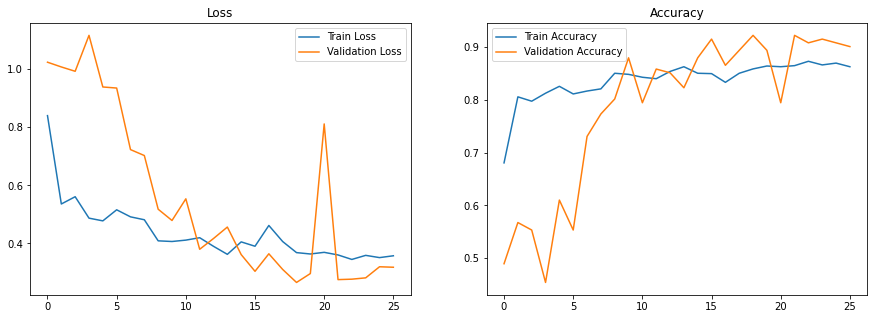

In [23]:
# Plotting model information again
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Loss')
ax[0].plot(trained_model.epoch, trained_model.history["loss"], label="Train Loss")
ax[0].plot(trained_model.epoch, trained_model.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(trained_model.epoch, trained_model.history["accuracy"], label="Train Accuracy")
ax[1].plot(trained_model.epoch, trained_model.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[1].legend()
print(model.evaluate(testing_data))

# Evaluation

In the end my final model was able to classify between images of living, bleached, and dead coral with a 90% accuracy. With an accuracy that high our model could be used effectively to classify our coral photos. That being said, let's address some possible shortcomings in my model. I think if these three shortcomings could be addressed it would greatly improve the neural network.

## Possible Shortcomings

### Class Imbalances

The data I used contains some large class imbalances. The data has around six times as many photos of living and bleached coral when compared to the images of our dead coral. Having similar numbers of each image type would help improve our model.

### Small Dataset

The dataset I used only had 1,500 images. This would likely reduce our models effectiveness in the field because our model has only seen a very limited set of images. It would only benefit the model to increase the amount and variety of the images used to train and build the model with. 

### More Field Accurate photos

The images I used to build this model are not from the Great Reef Census, in order to more effectively deploy this model it would make the most sense to train the neural network on user submitted images. In the feild pictures of corals could be taken at all sorts of angles, in a variety of lighting, and with varying image quality. Training the network on these images would help improve the models in the field performance.

## Future Research

### Species of Coral

At the current moment the model only picks between living, bleached, and dead coral. It could be possible to train the model to choose between different species of corals. That would help to understand what the general coral makeup of the reef is.

### Object Detection

Another step forward that could be done is by building an object detection model. You could build the model to mark bleached coral in large shots of the reef, or anything for that matter. You could mark trash in the reef, invasive species, or bleached coral. This would be helpful to visually see what areas of the reef are suffering. 

# Final Conclusion

In the end my model was able to classify my test data with an accuracy score of 90%. This is far better than just randomly guessing and much improved over my baseline neural network. Despite the mentioned shortcomings in my data, I think this model was a great success. With an accuracy score as high as 90% this model could be used to understand the general health of a reef system. I think this neural network was a great first step in using Machine learning to help the oceans. I really genuinely think if the improvements I have laid out were applied to a future model then that model could be very effective at helping monitor the reefs.